# CQF | Assigment for Module 3 Solution 

**Author**: 
Frank Salvador Ygnacio Rosas 

**Cohort**: January 2022

In [46]:
# Importing base packages
import matplotlib
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm, gmean
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot

# Import cufflinks
import cufflinks as cf
cf.set_config_file(
    offline=True, 
    dimensions=((1000,600)),
    theme= 'henanigans')

# Import plotly express for EF plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
px.defaults.template = "plotly_dark"
px.defaults.width = 950
px.defaults.height = 600

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.linewidth'] = 2.0

# Set max row to 300
pd.set_option('display.max_rows', 300)

# The impact of a Variation Reduction Method in Monte Carlo Simulations for Asian and Lookback Call options

## 1. Introduction

**The aim of this project is to evaluate the pricing results through Monte Carlo simulations for strong path-dependent options in terms of _efficiency_**. Before going into details, let's first define a general framework to explain what we mean by "efficiency".

Supposse there is an stochastic process $X$ (e.g., the asset price) and a function of interest $v$ (e.g., the contract valuation function). So, the estimation target through Monte Carlo simulations might be:

$$\mathop{\mathbb{E}}[v(X)]$$ 

Thus, for $N$ individual draws of $X$ such as $x_1, x_2, ..., x_N$, the Monte Carlo estimator for $\mathop{\mathbb{E}}[v(X)]$ will be:

$$\hat{v}_N = \frac{1}{N} \sum \limits _{i=1} ^ {N}v({x_i})$$

So, assuming observations of $X$ are _independent_, we can prove $\textrm{Cov}\big[v(x_i), v(x_{i+1})\big]=0$ due to $\rho\big( v(x_i), v(x_{i+1})\big) = 0$. Moreover, when $N\rightarrow\infty$, we will expect $\hat{v}_N \sim \mathbb{N}$ due to the **CLT**. In that sense, it is possible to assume each observation is _identical distributed_ with the same variance $\sigma^2$ for $X$. Therefore:

\begin{equation*}
\sqrt{ \mathop{\mathbb{V}ar[\hat{v}_N]}} = \sqrt{\mathop{\mathbb{V}ar\big[ \frac{1}{N} \sum \limits _{i=1} ^ {N}v({x_i}) \big]}} = \sqrt{ \frac{1}{N^2} \sum \limits _{i=1} ^ {N}\mathbb{V}ar\big[v({x_i})\big]} = \sqrt{ \frac{1}{N^2} \sum \limits _{i=1} ^ {N}\sigma^2} = \sqrt{ \frac{1}{N^2} (N\sigma^2) } = \frac{\sigma}{\sqrt{N}}
\end{equation*}

Important to notice that $\sigma \neq \hat{\sigma}$, being $\hat{\sigma}$ the **_realized standard deviation_** obtained in the simulations, such as:

\begin{equation*}
\hat{\sigma}_N=\sqrt{\mathop{\mathbb{V}ar}[\hat{v}_N]} = \sqrt{\mathop{\mathbb{E}}[(\hat{v}_N)^2] - (\mathop{\mathbb{E}}[\hat{v}_N])^2} = \sqrt{ \big(\frac{1}{N} \sum \limits _{i=1} ^ {N}v({x_i})^2\big) - \big(\frac{1}{N} \sum \limits _{i=1} ^ {N}v({x_i})\big)^2}
\end{equation*}

Finally, we can use $\hat{\sigma}$ instead of $\sigma$ in our $N$ simulations since the latter is unknown. Consequently, we get: 

$$\epsilon = \frac{\hat{\sigma}_N}{\sqrt{N}} \label{eq:standard_error} \tag{1}$$

where $\epsilon:=$ the _standard error_.

Generally speaking, $\epsilon$ tends to zero when $N$ increases. However, the unlimited increment of $N$ is impossible to reach in real applications. Even so, we need to achieve _convergence_ in our results, that is, get the same "fair price" for the options at any $N$. Thus, in this context, being "_efficient_" could be understood as _getting the desired outcome with the fewest involved resources_. This leads to the definition that an <ins>efficient Monte Carlo implementation is one that can guarantee _convergence_ for the minimum value of $N$ and $\epsilon$</ins>. Therefore, **the aim of this project will be to evaluate alternatives that could increase this _efficiency_ in Monte Carlo simulations by the implementation of _Variance Reduction_ techniques**.

In that sense, for the given exotic contract types, this project will test two different but comparable scenarios: 

1. **A Monte Carlo _without_ a variation reduction technique** ("_naive Monte Carlo_").
2. **A Monte Carlo _with_ a variation reduction technique**.

We compare these two scenarios using numerical results for the priced options and the estimated error for certain values of $N$. Particularly, for the Monte Carlo _with_ a variation reduction technique, we will use the **Antithetic Sampling** method, referenced by Peter Jackel **[1]** and Ren, Zhao and Ermon **[2]**. 

Any of the details will be explained and applied in each relevant section. 

## 2. The task 

### 2.1. General framework

Being $S$ the asset price, we will use the expected value of the _discounted payoff under the risk-neutral density_ $\mathbb{Q}$ to valuate the options. It has the form:

\begin{equation*}
    V(S,t) = e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}\big[\textrm{Payoff }(S_T)\big]
    \label{eq:EDP} \tag{2} 
\end{equation*}

This will be used for the appropiate payoff function of **Asian** and **Lookback options**. Therefore, we will check the following possibilities:

- Arithmetic Floating Strike Asian option
- Arithmetic Fixed Strike Asian option
- Geometric Floating Strike Asian option
- Geometric Fixed Strike Asian option
- Floating Strike Lookback option for the realized minimum of $S$ 
- Fixed Strike Lookback option for the realized maximum of $S$ 

The specific payoff functions will be defined in the next section. Also, due to the _put-call parity_, we will consider **_call_ options only** and **no early-exercise**.

So, we will use the **Euler-Maruyama scheme** to initialize the simulation for the underlying asset price. It follows the form:

\begin{align*} 
S_{t+\delta t} &\approx S_t \big(1+r\delta t+\sigma \phi_t\sqrt{\delta t} \big) \\
\phi_t &\sim \mathbb{N}(0,1) 
    \label{eq:EMRA} \tag{3}
\end{align*}

where its approximation scheme has an error of $O\big( \sqrt{\delta t} \big)$.

Notice it is possible to express $(3)$ in a time-step form, such as:

$$S_{t+\delta t} \approx S_t . e^{ ((r-\frac{1}{2}\sigma^2)\delta t + \sigma \phi_t\sqrt{\delta t}) } \tag{3.1.} $$ 


Thus, as an initial example, we may consider the following **sample data**:

\begin{align*} 
\text{Today's stock price }S_0 &=  100 \\ 
\text{Strike } E &=  100 \\
\text{Time to expire } (T-t) &=  1 \text{ year} \\
\text{volatility } \sigma &=  20\% \\
\text{risk free interest rate } r &=  5\% \\ 
\tag{3.2.}
\end{align*}

In that sense, we will drive our project considering the framework described above.

### 2.2. Derivative contracts

The contracts listed in section $2.1.$ will be described below, as well as some useful notation for the given options.

##### 2.2.1. Asian options

The payoff of an Asian option depends on the average of the underlying asset. This average is defined as a _new state variable_ (i.e., a sample variable) called $I$. There are two ways to establish it: _continuously_ and _discretely_. According to Willmott **[3]**, _path-dependent quantities are never measured continously_ in real life. Therefore, in this project **we will use a discrete sampling framework for $I$**.

So, let's define $I$ as:

$$I_K = \sum \limits _{i=1} ^ {K} {S(t_i)} \space\space, \space\space \textrm{being } K:= \textrm{sampling periods or dates}.$$ 

Thus, the discrete average $A$ for any Asian option could be defined as:

- Arithmetic form $A_{[a]}$: 

$$ A_{[a]} = \frac{1}{K} \sum \limits _{i=1} ^ {K} {S(t_i)}$$

Using the _Updating rule_ and the _Jump condition_ for $A_{[a]}$, we can say respectively:

$$ A_{[a]_i} = \frac{i-1}{i}A_{i-1} + \frac{1}{i} S_{(t_i)} \space\space\space \wedge \space\space\space V(S, A, t_{i}^-) = V\big(S, \frac{{i-1}}{i}A+\frac{1}{i}S, t_i^+\big)$$

- Geometric form $A_{[g]}$:

$$ A_{[g]} = e^{\big[\frac{1}{K} \sum\limits _{i=1} ^ {K}{ln(S(t_i))}\big]}$$

Using the _Updating rule_ and the _Jump condition_ for $A_{[g]}$, we can say respectively:

$$A_{[g]_i} = exp{\big[\frac{{i-1}}{i}ln(A_{i-1}) + \frac{1}{i}ln(S_i)\big]} \space\space\space \wedge \space\space\space V(S, A, t_{i}^-) = V\big(S,  exp{\big[\frac{{i-1}}{i}ln(A) + \frac{1}{i}ln(S)\big]}  ,t_i^+\big)$$

So, implementing any of these averages for $A$, we can define the $\textrm{Payoff}$ in terms of the strike types, such as:

- $\textrm{Floating Strike Payoff}$: $\space\space\space C_T = max(S - A, 0)$

- $\textrm{Fixed Strike Payoff}$: $\space\space\space C_T = max(A - E, 0)$


Finally, using the information above, we can set the appropiate $\textrm{Payoff}$ functions for each Asian contract type listed in $2.1.$, such as:

- $\textrm{Call Arithmetic Floating Strike Asian option}$:

$$\textrm{Payoff} = max(S - A_{[a]}, 0) \tag{4}$$

- $\textrm{Call Arithmetic Fixed Strike Asian option}$:

$$\textrm{Payoff} = max(A_{[a]} - E, 0) \tag{5}$$

- $\textrm{Call Geometric Floating Strike Asian option}$:

$$\textrm{Payoff} = max(S - A_{[g]}, 0) \tag{6}$$

- $\textrm{Call Geometric Fixed Strike Asian option}$:

$$\textrm{Payoff} = max(A_{[g]} - E, 0) \tag{7}$$

Notice we are under the risk-neutral framework. Thus, $(2)$ should be used to find the option value at any time $t$.

###### 2.2.1.  Lookback options

The payoff of a Lookback option is a function that depends on the _max_ or _min_ of the realized asset price over a certain time horizon of the option's life. In that sense, being $M$ the _new variable variable_ that tracks **discretely** the maximum or minimum of the underlying, we can say:

$$ M_{max} = \max_{0<i<n} (S(t_i)) \space\space \vee \space\space M_{min} = \min_{0<i<n} (S(t_i))$$

$\text{for } i = 1, 2, ...$

We can simplify this using the general discrete _updating rule_, such as:

$$M_i = {f}(S(t_i), M_{i-1})$$

$\text{being } f(\cdot):= min(\cdot) \small\vee max(\cdot)$.

In terms of the _Jump condition_ to apply across sampling dates $t_i$, this could be:

$$V(S, M, t_{i}^-) = V\big(S, f(S, M), t_{i}^+\big)$$

This leads to the general $\text{Payoff}$ functions:

- $\textrm{Floating Strike Payoff}$: $\space\space\space C_T = max(S - M, 0)$

- $\textrm{Fixed Strike Payoff}$: $\space\space\space C_T = max(M - E, 0)$

Finally, using the information above, we can set the appropiate $\textrm{Payoff}$ functions for each Lookback contract type listed in section $2.1.$, such as:

- $\textrm{Call Floating Strike Lookback option for the min. of } S$:

$$\textrm{Payoff} = max(S - M_{min}) \tag{8}$$

- $\textrm{Call Fixed Strike Lookback option for the max. of } S$:

$$\textrm{Payoff} = max(M_{max} - E) \tag{9}$$

Again, notice we are under the risk-neutral framework. Thus, $(2)$ should be used to find the option value at any time $t$.

## 3. Monte Carlo simulations

### 3.1. Naive Monte Carlo

Let's start by using Monte Carlo simulations _without_ a variation reduction technique for the given contracts. This will be useful also to compute the basic functions and classes for the further applications of this project. Therefore, we can apply the following steps:

**1)** **Define the initial parameters and generate simulations for each $S_i$ step**. 

In this case, we will define the intial parameters considering the **sample data** $(3.2.)$, such as:

- $S_0 = 100$
- $\delta t = 1/252$ ; i.e., a daily time step.
- $\sigma = 0.20$
- $r = 0.05$

With this, we are able to produce $S_i$ for $i = 1, ..., 251$ that follows **Euler-Maruyama** $(3)$. Notice that $\vec{\mathbf{S}} = [S_0, S_1, ..., S_{251}]$ works as a single realization vector, in this case, of 252 elements.

**2)** **Repeat the previous step $N$ times**. 

Since we are applying a _naive Monte Carlo_, we can set a value for $N$ as a first approximation. So, let's by using $N = 10^{3}$. Thus, we will get $10^{3}$ realizations for the vector $\vec{\mathbf{S}}$. In addition, just for ilustration, we can plot the $N$ drawn paths.

In [47]:
# defining base variables
s_0, T, tsteps, sigma, r, E = 100, 1, 252, 0.2, 0.05, 100

# number of realizations/draws N
N = int(10**3)

In [48]:
# asset path function 
def simulate_path_montecarlo(s0, mu, sigma, horizon, timesteps, n_sims, antithetic = False):
    """
    The original version of this function comes from:
        Source: Monte Carlo Methods. Python Lab. CQF Program. 
        Author: Kannan Singaravelu
        March, 2022.
    
    Here, we add a simple general Antithetic Variate sampling method.
    This is activated when the parameter `antithetic` is defined as True.
    We are going to use it only in section 3.2.
    """
    # Set the random seed for reproducibility
    # Same seed leads to the same set of random values
    np.random.seed(1500) 

    # Read parameters
    S0 = s0         # initial spot level
    r = mu          # mu = rf in risk neutral framework 
    T = horizon     # time horizion
    t = timesteps   # number of time steps
    n = n_sims      # number of simulation
    
    # Define dt
    dt = T/t        # length of time interval  
    
    # Simulating 'n' asset price paths with 't' timesteps
    S = np.zeros((t, n))
    S[0] = S0
    
    # in case antithetic sampling is activated
    if antithetic: n = int(n/2)    
    
    # base loop using Euler Maruyama
    for i in range(0, t-1):
        # random number generations from standard normal dist
        w = np.random.standard_normal(n)      
        # concat. and sampling rule in case antithetic param is activated
        if antithetic: w = np.concatenate((w,-w), axis=0) 
        # Euler Maruyama approx.
        S[i+1] = S[i] * (1 + r * dt + sigma * np.sqrt(dt) * w)            
    return S

In [49]:
# simulation of N paths 
spath = simulate_path_montecarlo(s_0, r, sigma, T, tsteps, N)

# asset path dataframe object
asset_path = pd.DataFrame(spath)

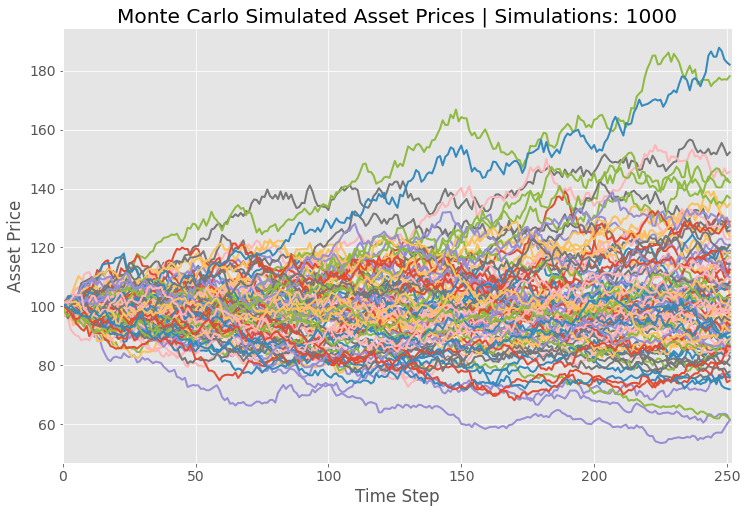

In [50]:
# plotting 100 first simulated asset paths
plt.plot(asset_path.iloc[:,:100])
plt.xlabel('Time Step')
plt.xlim(0,252)
plt.ylabel('Asset Price')
plt.title(f'Monte Carlo Simulated Asset Prices | Simulations: {N}')
plt.show()

**3)** **Calculate the _averages_ and the _min_ / _max_ functions of $S$**. 

First, since we are working through $N$ simulated random paths of $S$, it is better to use an appropiate notation to specificy in which path we are working on. So, we can denote:

$$ S^{j}_i \space\space\space,  \textrm{for}\space j=1, ..., N$$

which indicates the $i^{th}$ simulated time-step of the $j^{th}$ realization path. 

Now, with this, we can redefine each metric using its _updating rule_ form:

- Arithmetic Average ($\textrm{notation: }$'**aa**'): $\space\space A^j_{[a]_i} = \frac{i-1}{i}A^j_{i-1} + \frac{1}{i} S^j_{(t_i)}$
- Geometric Average ($\textrm{notation: }$'**ag**'): $\space\space A^j_{[g]_i} = exp{\big[\frac{{i-1}}{i}ln(A^j_{i-1}) + \frac{1}{i}ln(S^j_{(t_i)})\big]}$
- Max function ($\textrm{notation: }$'**max**'): $\space\space M^j_{max, i} = {max}(S^j_{(t_i)}, M^j_{i-1})$
- Min function ($\textrm{notation: }$'**min**'): $\space\space M^j_{min, }i = {min}(S^j_{(t_i)}, M^j_{i-1})$

Finally, to compute these metrics, we will use a $\textrm{21 days or monthly sampling}$ for $t_i$, such as:

* $i = 1, 22, 43, ...$

So, let's first define an ```UpdatingRules class``` to englobes all these metrics to be calculated using this sample interval. Just for illustration, we will draw a plot for each of them using a single realization path. 

In [51]:
# let's create an Updating Rule Class
# this will be useful for further applications
# notice this class use vectorization 
# this helps to reduce the computational cost of the task

class UpdatingRules(object):
    
    # init method
    def __init__(self, pathsMatrix, sample_step=1):
        # class variable of simulated asset prices
        self.pathsMatrix = pathsMatrix
        
        # check if sample step param fits the constraints
        if not isinstance(sample_step, int) or not (sample_step> 0): 
            # raise error in case sample-step input is wrong
            raise TypeError(
                "'sample_step' param should be a positive integer."
            )
            
        # class variable of simulated asset prices
        self.sample_step = sample_step
    
    # method 1: arithmetic average | base formulae
    def __arithAvg__(self, arrVect):
        return arrVect.mean(axis=0)
    
    # method 2: geometric average | base formulae
    def __geoAvg__(self, arrVect):
        return gmean(arrVect)
    
    # method 3: max value | base formulae
    def __maxPrice__(self, arrVect):        
        return arrVect.max(axis=0)
    
    # method 4: min value | base formulae
    def __minPrice__(self, arrVect):
        return arrVect.min(axis=0)
    
    # method to split path given sample dates
    def __splitPath__(self):
        # index vector for split process
        self.stepVector = \
        range(1, self.pathsMatrix.shape[0], self.sample_step)
        
        # split process and the resulting subseries 
        self.lstSiArr = \
        np.array_split(self.pathsMatrix, self.stepVector)
        
        # selection sampled prices based on index vector
        self.spriceMatrix = self.pathsMatrix[self.stepVector]
        
    # method to compute the state variable 
    def __computeStateVar__(self, function):
        
        # compute the state variable func. (e.g., average, max/min, etc.)
        lstSateVar = \
        [function(arrTemp) for arrTemp in self.lstSiArr]
        
        # def matrix with state var. values | avoid 1st value = S_0
        stateMatrix = np.array(lstSateVar[:-1])
        
        # compute index matrix for broadcasting 
        indexMatrix = np.array(
            (range(1,stateMatrix.shape[0]+1))
        ).reshape(-1,1)
        
        # >>> compute of updating rule based on "state func" param
        # user ask for Arithmetic Average Updt. Rule form
        if self.state_func == "aa":
            upRuleMatrix = ((1/indexMatrix) * (self.spriceMatrix)) + \
            (((indexMatrix - 1)/indexMatrix)*(stateMatrix))
        
        # user ask for Geometric Average Updt. Rule form
        elif self.state_func == "ag":
            _upRuleMatrix = ((1/indexMatrix) * (np.log(self.spriceMatrix))) + \
            (((indexMatrix - 1)/indexMatrix)*(np.log(stateMatrix))) 
            upRuleMatrix = np.e ** (_upRuleMatrix)
        
        # user ask for Max. Updt. Rule form
        elif self.state_func == "max":
            upRuleMatrix = np.maximum(self.spriceMatrix, stateMatrix)
        
        # user ask for Min. Updt. Rule form
        else:
            upRuleMatrix = np.minimum(self.spriceMatrix, stateMatrix)
        
        # fill updating rule matrix to fits pathsMatrix shape 
        fullRuleMatrix = np.repeat(
            upRuleMatrix, 
            repeats=[array.shape[0] for array in self.lstSiArr][1:], 
            axis=0
        )
        
        # insert initial S_0 vector into full updt rule matrix
        self.fullRuleMatrix = \
        np.insert(fullRuleMatrix, 0, self.pathsMatrix[0],0)          
        
    def compute(self, state_func):
                
        # allowed state func abbreviations
        allowedStateFuncNames =  ["aa", "ag", "max", "min"]
        
        # check if sample step param fits the constraints
        if not isinstance(state_func, str) or \
        not (state_func.lower() in allowedStateFuncNames): 
            # raise error in case sample-step input is wrong
            raise TypeError(
                f"'state_func' should be a string like {allowedStateFuncNames}."
            )        
            
        # redefine input str as lower case:
        self.state_func = state_func.lower()            
        
        # call the split process step
        self.__splitPath__()
        
        # if selected state function is Arithmetic Average
        if self.state_func == "aa":
            function = self.__arithAvg__
            
        # if selected state function is Geometric Average
        if self.state_func == "ag":
            function = self.__geoAvg__
            
        # if selected state function is Max funct.
        if self.state_func == "max":
            function = self.__maxPrice__
            
        # if selected state function is Min funct.
        if self.state_func == "min":
            function = self.__minPrice__          

        # compute state variable matrix
        self.__computeStateVar__(function)
        
        # return full updt rule matrix | same shape as paths matrix
        return self.fullRuleMatrix

In [52]:
# single path idx selected for plots, and defined sampleStep
jPath = 100
sampleStep = 21

* **Arithmetic Average** | 21 days or monthly sampling

In [53]:
# sampled arithmetic average for all simulated paths
metric = "aa"

# computing updating rules 
aritAverageArray = UpdatingRules(
    pathsMatrix=spath, sample_step=sampleStep
).compute(metric)
aritAverageDf = pd.DataFrame(aritAverageArray)

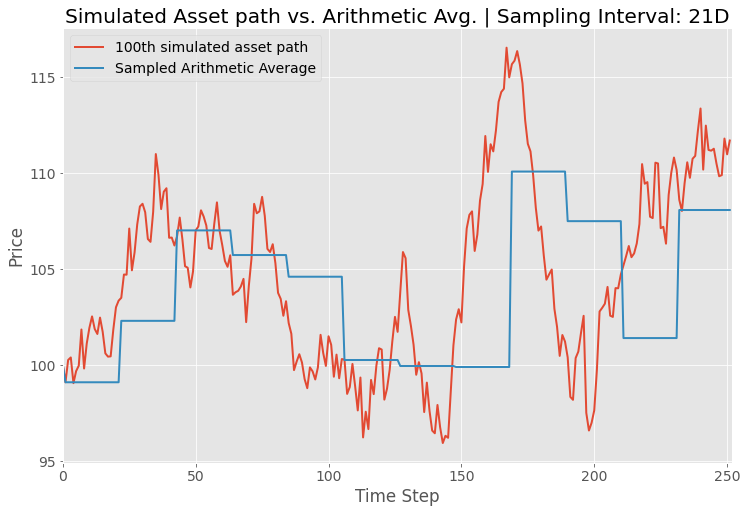

In [54]:
# plot single path with its sampled metric
plt.title(f"Simulated Asset path vs. Arithmetic Avg. | Sampling Interval: {sampleStep}D")
plt.plot(asset_path.iloc[:,jPath], label= f"{jPath}th simulated asset path")
plt.plot(aritAverageDf.iloc[:,jPath], label= f"Sampled Arithmetic Average")
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.xlim(0,252)
plt.show()

* **Geometric Average** | 21 days or monthly sampling

In [55]:
# sampled geometric average for all simulated paths
metric = "ag"

# computing updating rules 
geoAverageArray = UpdatingRules(
    pathsMatrix=spath, sample_step=sampleStep
).compute(metric)
geoAverageDf = pd.DataFrame(geoAverageArray)

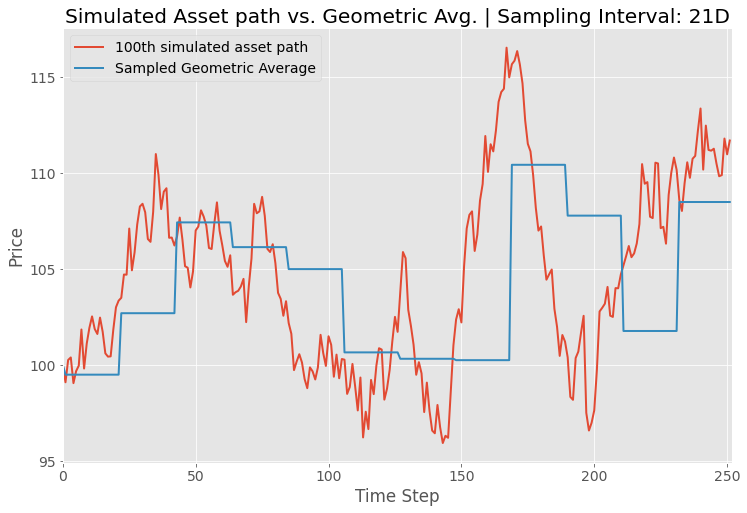

In [56]:
# plot single path with its sampled metric
plt.title(f"Simulated Asset path vs. Geometric Avg. | Sampling Interval: {sampleStep}D")
plt.plot(asset_path.iloc[:,jPath], label= f"{jPath}th simulated asset path")
plt.plot(geoAverageDf.iloc[:,jPath], label= f"Sampled Geometric Average")
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.xlim(0,252)
plt.show()

* **Max function** | 21 days or monthly sampling

In [57]:
# sampled max function for all simulated paths
metric = "max"

# computing updating rules 
maxFuncArray = UpdatingRules(
    pathsMatrix=spath, sample_step=sampleStep
).compute(metric)
maxFuncDf = pd.DataFrame(maxFuncArray)

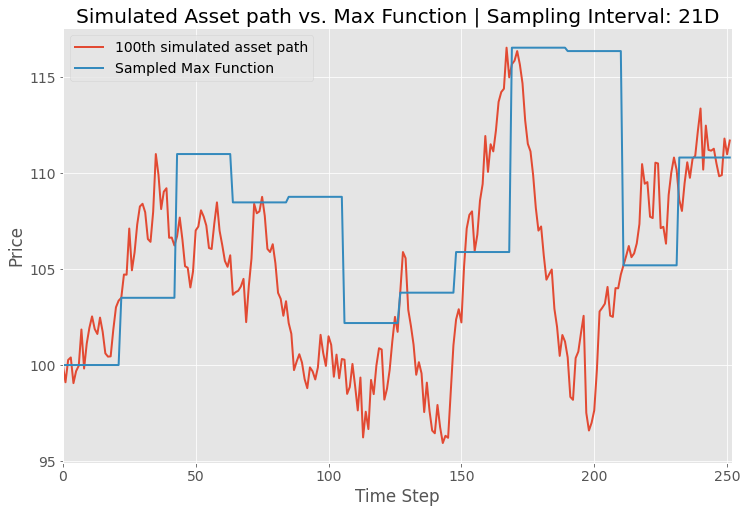

In [58]:
# plot single path with its sampled metric
plt.title(f"Simulated Asset path vs. Max Function | Sampling Interval: {sampleStep}D")
plt.plot(asset_path.iloc[:,jPath], label= f"{jPath}th simulated asset path")
plt.plot(maxFuncDf.iloc[:,jPath], label= f"Sampled Max Function")
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.xlim(0,252)
plt.show()

* **Min function** | 21 days or monthly sampling

In [59]:
# sampled max function for all simulated paths
metric = "min"

# computing updating rules 
minFuncArray = UpdatingRules(
    pathsMatrix=spath, sample_step=sampleStep
).compute(metric)
minFuncDf = pd.DataFrame(minFuncArray)

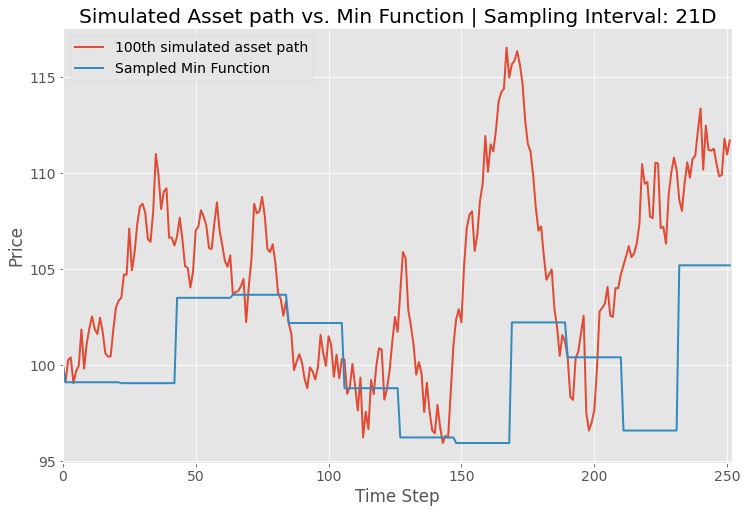

In [60]:
# plot single path with its sampled metric
plt.title(f"Simulated Asset path vs. Min Function | Sampling Interval: {sampleStep}D")
plt.plot(asset_path.iloc[:,jPath], label= f"{jPath}th simulated asset path")
plt.plot(minFuncDf.iloc[:,jPath], label= f"Sampled Min Function")
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.xlim(0,252)
plt.show()

At this stage, we are pretty confident that our method works. Although we are using only a single realization path for the plots, notice that we have computed the sampled metric for all of them. So, we can move to the next step using this data.

**4)** **Find the payoffs and its discounted average for all the $N$ realization paths**. 

Here, we will use equations $(4), (5), (6)$ & $(7)$ for **Asian options**, and $(8)$ & $(9)$ for **Lookback options** to find its payoffs at $T$ considering the type of sampled metric and, also, the sort of payoff required (_fixed_ or _floating_). Then, we will calculate the average value of these $N$ payoffs. Finally, with these results, we are able to apply statement $(2)$ to find its present value, that is, the "$\textrm{fair value}$" at $t_0$ for each contract type given the specific *sample data* defined in $(3.2.)$.

It is important to mention that, from now on, the plots will be less frequent since we are working with many paths and different combinations of payment methods for the two exotics types. Therefore, for convenience, we will present the results using ``dataframes``. 



In [61]:
# payoff functions for each contract type
def payoff_type(type_payoff, 
                priceMatrix, 
                metricMatrix, 
                time_expiry, 
                interest_rate, 
                strike = 100,
                discount_value = True):
    
    # allowed type of functions keywords
    allowedPayoffTypeNames =  ["float", "floating", "fixed"]
        
    # check if sample step param fits the constraints
    if not isinstance(type_payoff, str) or \
        not (type_payoff.lower() in allowedPayoffTypeNames): 
        # raise error in case sample-step input is wrong
        raise TypeError(
                f"'type_payoff' should be a string like {allowedPayoffTypeNames}."
            )
    
    # redefine input str as lower case:
    type_payoff = type_payoff.lower()
    
    # if the user selects a floating payoff type
    if type_payoff == "float" or type_payoff == "floating":  
        # find the payoff of the form "max(S - Metric, 0)" at T
        payoff = np.maximum(priceMatrix[-1] - metricMatrix[-1], 0)
    
    # otherwise, the user selects a fixed payoff type
    else:
        # find the payoff of the form "max(Metric - E, 0)" at T
        payoff = np.maximum(metricMatrix[-1] - strike, 0)
    
    # if user wants to get the discounted value:
    if discount_value:
        # find the disct. value of the expected payoff and return it
        # notice we will round the final value up to two decimals 
        # since there is no a sort of "micro-cents"
        return round(np.exp(-interest_rate*time_expiry) * np.mean(payoff), 2)           
    
    # if user wants to get the vecotr of payoff values at T
    else:
        # return payoff vector of N elements, being N:= number simulations
        return payoff

In [62]:
# Arithmetic Floating Strike Asian option
arithAsianFloatingCall = payoff_type("floating", spath, aritAverageArray, T, r, strike = E)

# Arithmetic Fixed Strike Asian option
arithAsianFixedCall = payoff_type("fixed", spath, aritAverageArray, T, r, strike = E)

# Geometric Floating Strike Asian option
geoAsianFloatingCall = payoff_type("floating", spath, geoAverageArray, T, r, strike = E)

# Geometric Fixed Strike Asian option
geoAsianFixedCall = payoff_type("fixed", spath, geoAverageArray, T, r, strike = E)

# Floating Strike Lookback option for the realized minimum of 𝑆
minLookbackFloatingCall = payoff_type("floating", spath, minFuncArray, T, r, strike = E)

# Fixed Strike Lookback option for the realized maximum of 𝑆
maxLookbackFixedCall = payoff_type("fixed", spath, maxFuncArray, T, r, strike = E)

In [63]:
# let's create a dataframe to report each option fair value
dictInfoFirstNaiveSimulations = {
    "N-simulations": [N], 
    "arithAsianFloatingCall": [arithAsianFloatingCall], 
    "arithAsianFixedCall": [arithAsianFixedCall],
    "geoAsianFloatingCall": [geoAsianFloatingCall],
    "geoAsianFixedCall": [geoAsianFixedCall],
    "minLookbackFloatingCall": [minLookbackFloatingCall],
    "maxLookbackFixedCall": [maxLookbackFixedCall]
}

# define the results dataframe
dfNaiveMonteCarlo = pd.DataFrame(dictInfoFirstNaiveSimulations)

In [64]:
# final results in dataframe form
print(">> Naive Monte Carlo | Fair values for the given exotics at t0:")
dfNaiveMonteCarlo

>> Naive Monte Carlo | Fair values for the given exotics at t0:


,N-simulations,arithAsianFloatingCall,arithAsianFixedCall,geoAsianFloatingCall,geoAsianFixedCall,minLookbackFloatingCall,maxLookbackFixedCall
0,1000,2.89,9.18,2.7,9.41,5.27,11.76


The single row dataframe above contains the results of our first **Naive Monte Carlo simulation without a reduction variation technique**. However, since we are interested in $\epsilon$ as well, we can add a new step to find it for a later comparison.

**5)** **Find the standard error $\epsilon$ for the $N$ realization paths**. 

Here, we are going to use equation $(1)$ to find the values of $\epsilon$ for the $N$ $\textrm{Payoffs}$ at $T$.  We will use the same ``payoff_type`` function, but with the parameter ``discount_value = False``. This will allow us to get the vector of $\textrm{Payoffs}$ at $T$ and, consequently, find its $\epsilon$ for the given exotic contract.

In [65]:
# Arithmetic Floating Strike Asian option \ standard error
arithAsianFloatingCallVector = payoff_type(
    "floating", spath, aritAverageArray, T, r, strike = E, discount_value=False
)
arithAsianFloatingCallEpsilon = arithAsianFloatingCallVector.std()/np.sqrt(N)

# Arithmetic Fixed Strike Asian option \ standard error
arithAsianFixedCallVector = payoff_type(
    "fixed", spath, aritAverageArray, T, r, strike = E, discount_value=False
)
arithAsianFixedCallEpsilon = arithAsianFixedCallVector.std()/np.sqrt(N)

# Geometric Floating Strike Asian option \ standard error
geoAsianFloatingCallVector = payoff_type(
    "floating", spath, geoAverageArray, T, r, strike = E, discount_value=False
)
geoAsianFloatingCallEpsilon = geoAsianFloatingCallVector.std()/np.sqrt(N)

# Geometric Fixed Strike Asian option \ standard error
geoAsianFixedCallVector = payoff_type(
    "fixed", spath, geoAverageArray, T, r, strike = E, discount_value=False
)
geoAsianFixedCallEpsilon = geoAsianFixedCallVector.std()/np.sqrt(N)

# Floating Strike Lookback option for the realized minimum of 𝑆 \ standard error
minLookbackFloatingCallVector = payoff_type(
    "floating", spath, minFuncArray, T, r, strike = E, discount_value=False
)
minLookbackFloatingCallEpsilon = minLookbackFloatingCallVector.std()/np.sqrt(N)

# Fixed Strike Lookback option for the realized maximum of 𝑆 \ standard error
maxLookbackFixedCallVector = payoff_type(
    "fixed", spath, maxFuncArray, T, r, strike = E, discount_value=False
)
maxLookbackFixedCallEpsilon = maxLookbackFixedCallVector.std()/np.sqrt(N)

In [66]:
# let's create a dataframe to report different epsilons
dictInfoFirstNaiveEpsilsonValues = {
    "N-simulations": [N], 
    "arithAsianFloatingCall": [arithAsianFloatingCallEpsilon], 
    "arithAsianFixedCall": [arithAsianFixedCallEpsilon],
    "geoAsianFloatingCall": [geoAsianFloatingCallEpsilon],
    "geoAsianFixedCall": [geoAsianFixedCallEpsilon],
    "minLookbackFloatingCall": [minLookbackFloatingCallEpsilon],
    "maxLookbackFixedCall": [maxLookbackFixedCallEpsilon]
}

# define the results dataframe
dfNaiveMontecarloEpsilon = pd.DataFrame(dictInfoFirstNaiveEpsilsonValues)

In [67]:
# standard error for each N path given exotic function type
print(">> Naive Monte Carlo | Standard error of the calculations for each exotic at T:")
dfNaiveMontecarloEpsilon

>> Naive Monte Carlo | Standard error of the calculations for each exotic at T:


,N-simulations,arithAsianFloatingCall,arithAsianFixedCall,geoAsianFloatingCall,geoAsianFixedCall,minLookbackFloatingCall,maxLookbackFixedCall
0,1000,0.146833,0.446003,0.142668,0.451162,0.191758,0.503262


Now, to finish our _Naive Montecarlo_, let's collect more results testing our experiment for many values of $N$.

To do that, let's define a simple rule, such as:

$$N = 10^{{m}}\space, \space\space m\in\mathbb{N} $$ 

Here, we will get different values for the standard error and the exotics based on the values taken by $N$. The idea behind this is to check how these two results changes as long as $N$ increases. 

So, since we've already use $10^{3}$, let's define $m =$ {$1, 2, 4, 5, 6$}. With this different values for $m$, we will repeat the whole process of our _Naive Montecarlo_ to get the values for the exotics and its $\epsilon$ of the calculations. At the end, we will collect all this information with the results we've already have in our ``dataframe``.

Notice we are going to preserve the given **sample data** $(3.2.)$ and the sampling parameter ``sampleStep = 21`` to make our results comparable.

In [68]:
# values for m
m = [1,2,4,5,6]

# list that defines many values for N
NVals = [10** mVal for mVal in m] 

# lets define a list with the metrics to compute
# important to preserve this order for a quicky append to the base df
metrics = ["aa", "ag", "min", "max"]

In [69]:
# don't worry about this loop...
# it takes less than 20 seconds for all the simulations!

# empty list to collect the new information for each N value
lstInfoOptionsNMontecarlo, lsttInfoErrorsNMontecarlo = [], []

# iteration thru each N value 
for nVal in NVals:
    
    # empty sublist to collect results
    optionValues, calStandardError = [], []    
    
    # simulate the paths given value of N. 
    spathTemp = simulate_path_montecarlo(
        s_0, r, sigma, T, tsteps, nVal
    ) 
    
    # appending nVal to empty lists before fill them
    optionValues.append(nVal)
    calStandardError.append(nVal)
    
    # iteration per metric
    for metricVal in metrics:
        
        # computing updating rule array
        updatingRuleArray = UpdatingRules(
                    pathsMatrix=spathTemp, sample_step=sampleStep
                ).compute(metricVal)        
        
        # since we are not working with floating strike for max metric func.
        if metricVal != "max":

            # computing its floating version for the payoffs at T
            floatPayoffVect = payoff_type(
                "floating", spathTemp, updatingRuleArray, T, r, 
                strike = E, discount_value=False
            )        

            # finding its discounted present val for floating version
            # notice we will round the final value up to two decimals 
            # since there is no a sort of "micro-cents"             
            floatPayoffDValue = round(np.exp(-r*T) * np.mean(floatPayoffVect), 2)      

            # finding its standard error for floating version
            floatStandardErrorVal = floatPayoffVect.std()/np.sqrt(nVal)    

            #saving floating information
            optionValues.append(floatPayoffDValue)     
            calStandardError.append(floatStandardErrorVal)            

        # since we are not working with fixed strike for min metric func.        
        if metricVal != "min":\
            # computing its fixed version for the payoffs at T
            fixedPayoffVect = payoff_type(
                "fixed", spathTemp, updatingRuleArray, T, r, 
                strike = E, discount_value=False
            )        

            # finding its discounted present val for floating version
            # notice we will round the final value up to two decimals 
            # since there is no a sort of "micro-cents"            
            fixedPayoffDValue = round(np.exp(-r*T) * np.mean(fixedPayoffVect), 2)      

            # finding its standard error for floating version
            fixedStandardErrorVal = fixedPayoffVect.std()/np.sqrt(nVal)   
            
            #saving fixed information
            optionValues.append(fixedPayoffDValue)     
            calStandardError.append(fixedStandardErrorVal) 
            
    # inserting sub lists to general list to make list of lists
    lstInfoOptionsNMontecarlo.append(optionValues)
    lsttInfoErrorsNMontecarlo.append(calStandardError)

In [70]:
# creating final dataframe with options values for Naive Monte Carlo
naiveMontecarloOptionsVal = pd.concat(
    [
        dfNaiveMonteCarlo, 
        pd.DataFrame(
            lstInfoOptionsNMontecarlo, 
            columns = dfNaiveMonteCarlo.columns
        )
    ]
)
# sort values of the dataframe based on N and reset its index
naiveMontecarloOptionsVal = \
naiveMontecarloOptionsVal.sort_values("N-simulations").reset_index(drop=True)
naiveMontecarloOptionsVal.index = list(range(1,max(m)+1))

# creating final dataframe with standard error for Naive Monte Carlo
naiveMontecarloStandardError = pd.concat(
    [
        dfNaiveMontecarloEpsilon, 
        pd.DataFrame(
            lsttInfoErrorsNMontecarlo, 
            columns = dfNaiveMontecarloEpsilon.columns
        )
    ]
)
# sort values of the dataframe based on N and reset its index
naiveMontecarloStandardError = \
naiveMontecarloStandardError.sort_values("N-simulations").reset_index(drop=True)
naiveMontecarloStandardError.index = list(range(1,max(m)+1))

In [71]:
print("Naive Monte Carlo | Priced Exotics given N simulations:")
# option values for different N simulations
naiveMontecarloOptionsVal 

Naive Monte Carlo | Priced Exotics given N simulations:


,N-simulations,arithAsianFloatingCall,arithAsianFixedCall,geoAsianFloatingCall,geoAsianFixedCall,minLookbackFloatingCall,maxLookbackFixedCall
1,10,2.92,3.81,2.72,3.97,4.71,5.31
2,100,3.07,8.02,2.88,8.26,5.71,10.58
3,1000,2.89,9.18,2.70,9.41,5.27,11.76
4,10000,2.80,9.51,2.61,9.74,5.28,12.17
5,100000,2.83,9.66,2.64,9.89,5.34,12.30
6,1000000,2.82,9.55,2.63,9.79,5.32,12.20


In [72]:
print("Naive Monte Carlo | Standard Error of the calculations given N simulations:")
# standard error calculated for different N simulations
naiveMontecarloStandardError

Naive Monte Carlo | Standard Error of the calculations given N simulations:


,N-simulations,arithAsianFloatingCall,arithAsianFixedCall,geoAsianFloatingCall,geoAsianFixedCall,minLookbackFloatingCall,maxLookbackFixedCall
1,10,0.968044,2.030730,0.923405,2.083786,1.425757,2.510671
2,100,0.522917,1.200746,0.511497,1.216442,0.667934,1.359415
3,1000,0.146833,0.446003,0.142668,0.451162,0.191758,0.503262
4,10000,0.043592,0.142082,0.042260,0.143755,0.059283,0.159970
5,100000,0.013892,0.045094,0.013467,0.045627,0.018866,0.050813
6,1000000,0.004387,0.014128,0.004254,0.014296,0.005966,0.015945


Let's plot tese results see how the option value and the standard errors vary through different values of $N$. 

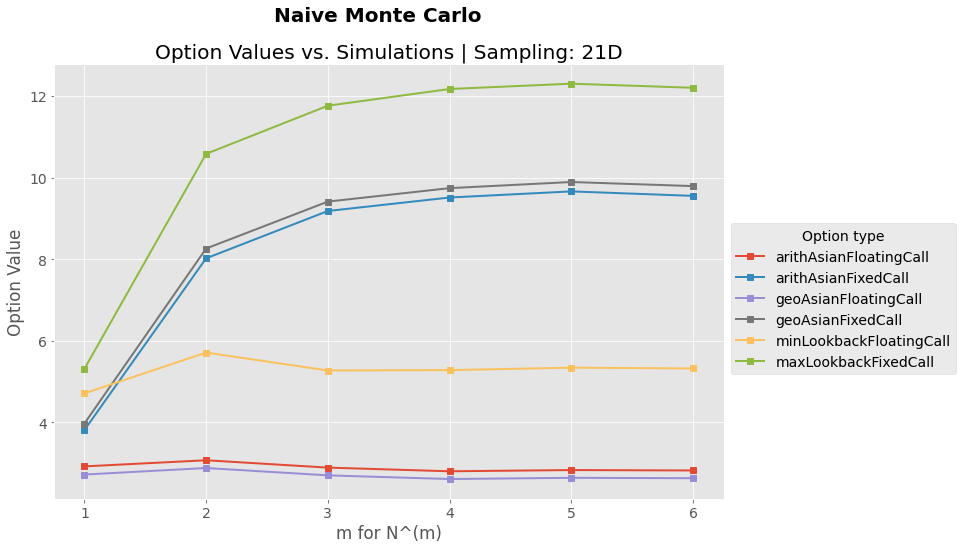

In [73]:
# plot option values per number of Naive Monte Carlo simulations
plt.suptitle("Naive Monte Carlo", size=20, fontweight="heavy")
plt.title(f"Option Values vs. Simulations | Sampling: {sampleStep}D")
plt.plot(naiveMontecarloOptionsVal[naiveMontecarloOptionsVal.columns[1:]], marker="s")
plt.legend(
    naiveMontecarloOptionsVal.columns[1:], 
    bbox_to_anchor=(1,.65), 
    title="Option type", 
    loc="upper left"
)
plt.xlabel("m for N^(m)")
plt.ylabel('Option Value')
plt.show()

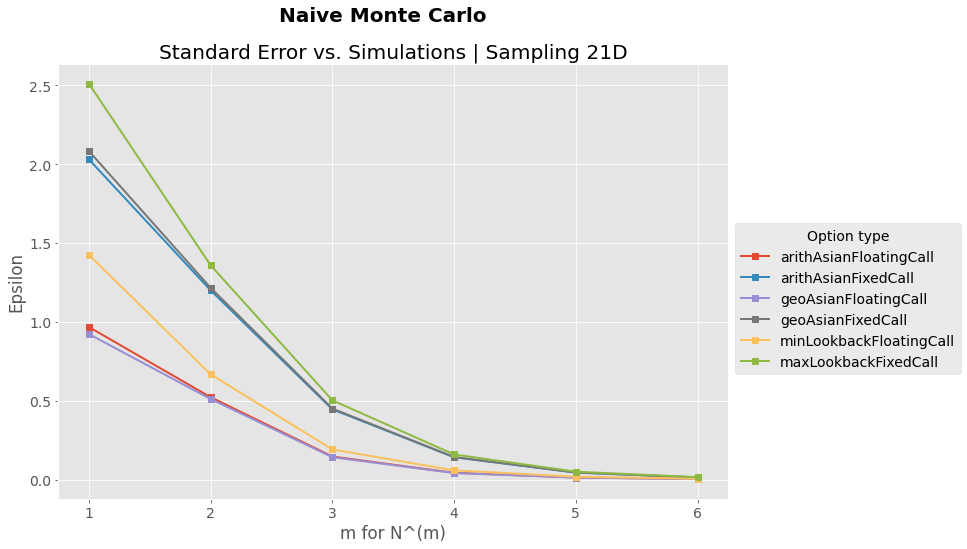

In [74]:
# plot standard error of Naive Monte Carlo simulations by option type
plt.suptitle("Naive Monte Carlo", size=20, fontweight="heavy")
plt.title(f"Standard Error vs. Simulations | Sampling {sampleStep}D")
plt.plot(naiveMontecarloStandardError[naiveMontecarloStandardError.columns[1:]], marker="s")
plt.legend(
    naiveMontecarloStandardError.columns[1:],
    bbox_to_anchor=(1,.65), 
    title="Option type", 
    loc="upper left"
)
plt.xlabel("m for N^(m)")
plt.ylabel('Epsilon')
plt.show()

As a final remark, we can say that, as $N$ increases, the price for each exotic _tends_ to converge to a single value. Nevertheless, at this point it is difficult to ensure a sort of strictly _convergence_. Notice this "tendency" to a single "fair value" arrives only for the largest $N$, that is, when the standard error tends to zero. Moreover, it is important to mention there are similarities in the evolution of the price based on whether its contract payoff function is floating or fixed.

Now, we are able to repeat this process but with the implementation of our **Variation Reduction Technique**.

### 3.2. Monte Carlo with a Variation Reduction Technique — the _Antithetic Sampling_ method

#### 3.2.1. Basic ideas

To get a better understanding of what **Antithetic Sampling** method is, and how we can use it to reduce the variance of our Monte Carlo estimator, we should first appreciate what _Antithetic Variables_ are.

So, let's imagine two  _identical distributed_ random variables $X_1$ and $X_2$. The mean of them can be defined simply as $\hat{x} = \frac{X_1 + X_2}{2}$. From this, we can say:

\begin{equation*}
\mathbb{V}ar[\hat{x}] = \frac{1}{4}\big( \mathbb{V}ar[X_1] + \mathbb{V}ar[X_2] + 2\textrm{Cov}[X_1, X_2] \big)
\end{equation*}

Here, it is obvious that $\mathbb{V}ar[\hat{x}]$ can be reduced only if $\textrm{Cov}[X_1, X_2] < 0$ or, more precisely, when $X_1$ and $X_2$ are _negative correlated_. Thus, **any pair of variables with negative correlation might be very helpful to reduce variance**. This is the intuitive definition of **Antithetic Variables**.

Now, we can easily define what **Antithetic Sampling** method is:

> **Antithetic Sampling allows a reduction of the variance of a Monte Carlo estimator by the use of Antithetic Variables**; that is, by drawing negative correlated samples instead of independent ones.

Although its simple interpretation, the topic is very deep. For instance, the definition of an effective framework to get correlation structures is not quite easy and varies from application to application. The subject is even more complex if we are interested in defining an adaptive scheme to get well-correlated samples that could cancel out first-order errors. Thus, to see a general description about these issues and how to overcome them, check **[2]**.

Now, considering our limitations, _how to apply this to our problem?_ According to Jackel **[1]**, for any single random draw, its "mirror" path has the same probability. This means that, if our Gaussian vector is $x_i$ (as we said in the introduction of this project), we can evaluate $v_i = v(x_i)$ and $\tilde{v_i} = v(-x_i)$ as two _identical distributed_ samples. However, to work with the standard error $\epsilon$, we need to ensure _independency_ among draws. So, instead of work over $v_i$ and $\tilde{v_i}$, we can consider:

$$\hat{v}_i = \frac{1}{2}(v(x_i)+v(-x_i)) \tag{10}$$ 

being $\hat{v}_i$ our new **individual sample**.

Thus, in order to get $N$ random draws, we should generate just $\frac{N}{2}$ realization paths and apply rule $(10)$ to get our individual samples. Notice $\hat{v}_1$, $\hat{v}_2$,...   are _independet_, so $\epsilon$ can be estimated correctly. Important to mention that each $\hat{v}_i$ needs two calculations, but just one generated random vector. This is, perhaps, the computational advantage of this method that we will expect can be reflected in an _efficient convergence_.

#### 3.2.1. The pythonic implementation

In our pythonic framework, this method can be achieved by drawing $\frac{N}{2}$ random paths using `numpy`. Them, we concatenate the original random vector with its duplicated version, but changing the sign of their values. Finally, we apply rule $(10)$ to get our new individual sample, using it during the asset path generation in the **Euler-Maruyama scheme**. 

This was already done in the ``simulate_path_montecarlo`` function. We need just to define the parameter `antithetic = True` to activate it.

So, let's replicate our general experiment for the given exotics using this _reduction variation technique_ to compare results.

In [75]:
# values for m
m = [1,2,3,4,5,6]

# list that defines many values for N
NVals = [10** mVal for mVal in m] 

# lets define a list with the metrics to compute
# important to preserve this order for a quicky append to the base df
metrics = ["aa", "ag", "min", "max"]

In [76]:
# we repeat the general iteration done in Naive Montecarlo
# in this case, we will use the 'antithetic' parameter := True

# empty list to collect the new information for each N value
lstInfoOptionsMontecarloAnti, lstInfoErrorsMontecarloAnti = [], []

# iteration thru each N value 
for nVal in NVals:
    
    # empty sublist to collect results
    optionValues, calStandardError = [], []    
    
    # simulate the paths given value of N
    # here we will activate antithetic parameter
    spathTemp = simulate_path_montecarlo(
        s_0, r, sigma, T, tsteps, nVal, antithetic = True
    ) 
    
    # appending nVal to empty lists before fill them
    optionValues.append(nVal)
    calStandardError.append(nVal)
    
    # iteration per metric
    for metricVal in metrics:
        
        # computing updating rule array
        updatingRuleArray = UpdatingRules(
                    pathsMatrix=spathTemp, sample_step=sampleStep
                ).compute(metricVal)        
        
        # since we are not working with floating strike for max metric func.
        if metricVal != "max":

            # computing its floating version for the payoffs at T
            floatPayoffVect = payoff_type(
                "floating", spathTemp, updatingRuleArray, T, r, 
                strike = E, discount_value=False
            )        

            # finding its discounted present val for floating version
            # notice we will round the final value up to two decimals 
            # since there is no a sort of "micro-cents"             
            floatPayoffDValue = round(np.exp(-r*T) * np.mean(floatPayoffVect), 2)      

            # finding its standard error for floating version
            floatStandardErrorVal = floatPayoffVect.std()/np.sqrt(nVal)    

            #saving floating information
            optionValues.append(floatPayoffDValue)     
            calStandardError.append(floatStandardErrorVal)            

        # since we are not working with fixed strike for min metric func.        
        if metricVal != "min":\
            # computing its fixed version for the payoffs at T
            fixedPayoffVect = payoff_type(
                "fixed", spathTemp, updatingRuleArray, T, r, 
                strike = E, discount_value=False
            )        

            # finding its discounted present val for floating version
            # notice we will round the final value up to two decimals 
            # since there is no a sort of "micro-cents"             
            fixedPayoffDValue = round(np.exp(-r*T) * np.mean(fixedPayoffVect), 2)      

            # finding its standard error for floating version
            fixedStandardErrorVal = fixedPayoffVect.std()/np.sqrt(nVal)   
            
            #saving fixed information
            optionValues.append(fixedPayoffDValue)     
            calStandardError.append(fixedStandardErrorVal) 
            
    # inserting sub lists to general list to make list of lists
    lstInfoOptionsMontecarloAnti.append(optionValues)
    lstInfoErrorsMontecarloAnti.append(calStandardError)

In [77]:
# creating final dataframe with options values for Monte Carlo with Var. Red. Techni.
antiMontecarloOptionsVal = pd.DataFrame(
    lstInfoOptionsMontecarloAnti, 
    columns = dfNaiveMonteCarlo.columns
)
# sort values of the dataframe based on N and reset its index
antiMontecarloOptionsVal.index = list(range(1,max(m)+1))

# creating final dataframe with standard error for Monte Carlo with Var. Red. Techni.
antiMontecarloStandardError = pd.DataFrame(
    lstInfoErrorsMontecarloAnti, 
    columns = dfNaiveMonteCarlo.columns
)
# sort values of the dataframe based on N and reset its index
antiMontecarloStandardError.index = list(range(1,max(m)+1))

In [78]:
print("Monte Carlo with Antithetic Sampling | Priced Exotics given N simulations:")
# option values for different N simulations
antiMontecarloOptionsVal

Monte Carlo with Antithetic Sampling | Priced Exotics given N simulations:


,N-simulations,arithAsianFloatingCall,arithAsianFixedCall,geoAsianFloatingCall,geoAsianFixedCall,minLookbackFloatingCall,maxLookbackFixedCall
1,10,3.12,15.64,2.94,15.88,6.75,19.80
2,100,2.66,8.89,2.46,9.12,5.11,11.48
3,1000,2.68,9.24,2.49,9.48,5.20,11.85
4,10000,2.79,9.50,2.60,9.73,5.26,12.12
5,100000,2.83,9.55,2.64,9.78,5.33,12.20
6,1000000,2.82,9.55,2.63,9.78,5.32,12.20


In [79]:
print("Monte Carlo with Antithetic Sampling | Standard Error of the calculations given N simulations:")
# standard error calculated for different N simulations
antiMontecarloStandardError

Monte Carlo with Antithetic Sampling | Standard Error of the calculations given N simulations:


,N-simulations,arithAsianFloatingCall,arithAsianFixedCall,geoAsianFloatingCall,geoAsianFixedCall,minLookbackFloatingCall,maxLookbackFixedCall
1,10,1.786807,6.426963,1.746666,6.483754,2.655532,7.464661
2,100,0.406588,1.269849,0.393021,1.286516,0.568144,1.458527
3,1000,0.134075,0.429624,0.129957,0.434855,0.184468,0.486652
4,10000,0.042898,0.139802,0.041534,0.141496,0.058112,0.157851
5,100000,0.013947,0.044633,0.013526,0.045163,0.018928,0.050376
6,1000000,0.004389,0.014113,0.004255,0.014280,0.005965,0.015930


Finally, let's plot to see how the option value and the standard errors vary through different values of $N$. 

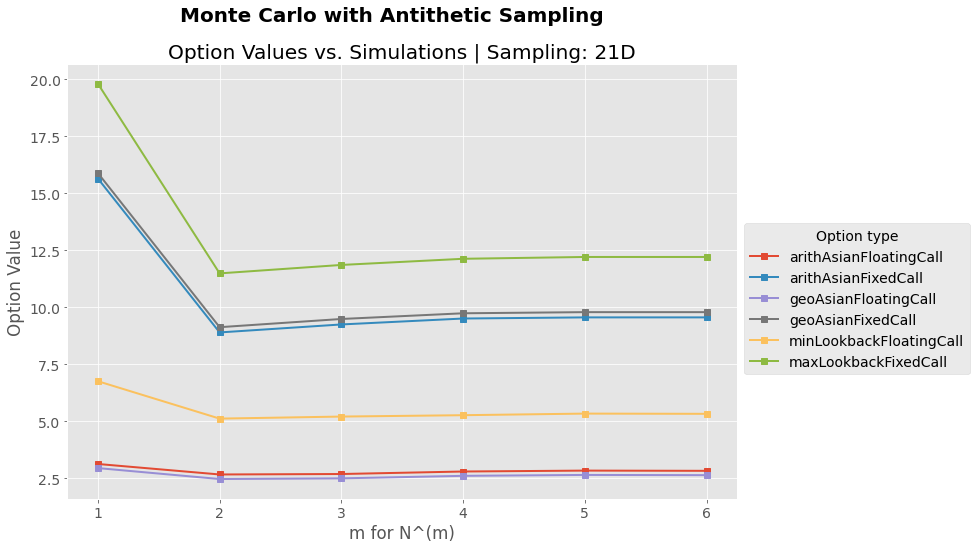

In [80]:
# plot option values per number of simulations of Monte Carlo with Var. Reduction Techq.
plt.suptitle("Monte Carlo with Antithetic Sampling", size=20, fontweight="heavy")
plt.title(f"Option Values vs. Simulations | Sampling: {sampleStep}D")
plt.plot(antiMontecarloOptionsVal[antiMontecarloOptionsVal.columns[1:]], marker="s")
plt.legend(
    antiMontecarloOptionsVal.columns[1:], 
    bbox_to_anchor=(1,.65), 
    title="Option type", 
    loc="upper left"
)
plt.xlabel("m for N^(m)")
plt.ylabel('Option Value')
plt.show()

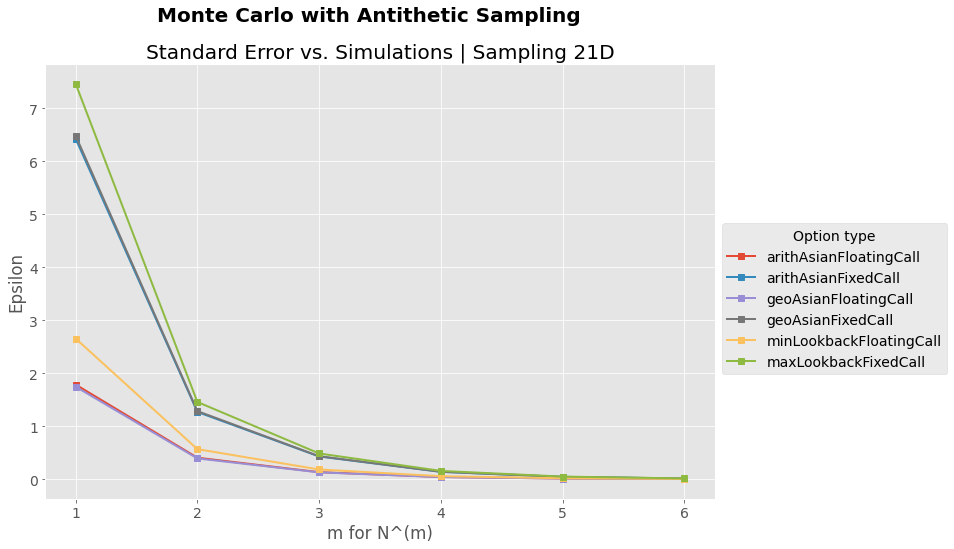

In [81]:
# plot standard error of simulations of Monte Carlo with Var. Reduction Techq.
plt.suptitle("Monte Carlo with Antithetic Sampling", size=20, fontweight="heavy")
plt.title(f"Standard Error vs. Simulations | Sampling {sampleStep}D")
plt.plot(antiMontecarloStandardError[antiMontecarloStandardError.columns[1:]], marker="s")
plt.legend(
    antiMontecarloStandardError.columns[1:],
    bbox_to_anchor=(1,.65), 
    title="Option type", 
    loc="upper left"
)
plt.xlabel("m for N^(m)")
plt.ylabel('Epsilon')
plt.show()

As a final remark, we could say that there is some _convergence_ under the **Monte Carlo with Antithetic Sampling** method since the $10^5$ and $10^6$ simulations return the same "fair price" for most of the contracts. In comparison, none of the simulations under the **Naive Monte Carlo** get a unique "fair value"; some of them are close, but they are not the same. We will discuss more about this in the next section.

Moreover, except from the first $10^{1}$ simulations, it is possible to say that the option values are relatively "stable" for a certain range under the _Variation Reduction Technique_ framework, which is not the case for the _naive_ implementation. However, notice that there are some exotic types (such as the _floating_ exotics) that preserves, more or less, stability up from the $10^2$ simulations in the latter scenario.

Finally, it is important to mention that the _standard error_ $\epsilon$ is essentially the same for $N > 10^2$ in both methods. So, perhaps we might consider a new way to stablish a sort of "_winner_", not just by seeing the shape of the plots, but aslo by taking into consideration the **estimation error** as our key evaluation concept.

### 3.3. The _estimation error_  — the final decision

An **estimation error** can be define simply as the difference between the estimated parameter $\hat{\theta}$ and the real parameter $\theta$, such as:

$$ \omega = \hat{\theta} - \theta$$

Now, we know by the CQF lectures that the **Monte Carlo Estimator is _unbiased_ and _consistent_**; i.e., it fits the condition:

$$ \hat{v}_N \overset{p}{\to} v \textrm{ as } N\rightarrow \infty$$

Thus, since we are working with an _unbiased_ estimator, we can consider $\omega \rightarrow 0$ as possible up to some point. Desirable but not necessarily achievable, we will seek $\omega=0$, that is, **_strictly convergence_** in the evaluation of our Monte Carlo results.

So, to decide which method _leads to a convergent solution_, we will define the option value obtained in the largest simulation as our "real paramter", that is, ${\theta}^{(q)} := V^{(q)}_{max(N)}$ for each contract type $q$. So, we will expect that, for each $\hat{V}^{\space(q)}_{N_1}, \hat{V}^{\space(q)}_{N_2}$,..., its respective $\omega^{(q)}$ tends or even achieve $0$ as long as $N$ increases. 

In our pythonic framework, this can be done easily by a few lines of code. 

In [82]:
# compute the real parameter vector from the largest N simulations

# max simulation done in Naive Monte Carlo
maxNaiveN = naiveMontecarloOptionsVal['N-simulations'].max()
# max simulation done in Monte Carlo with Var. Reduction Technique
maxAntiN = antiMontecarloOptionsVal['N-simulations'].max()

# real parameter for Naive Monte Carlo
thetaNaive = \
naiveMontecarloOptionsVal[
    naiveMontecarloOptionsVal['N-simulations'] == maxNaiveN 
].iloc[:,1:]
# estimated parameters for Naive Monte Carlo
thetaHatNaive = \
naiveMontecarloOptionsVal[
    naiveMontecarloOptionsVal['N-simulations'] != maxNaiveN 
].iloc[:,1:]


# real parameter for Monte Carlo with Variation Reduction Technique
thetaAnti = \
antiMontecarloOptionsVal[
    antiMontecarloOptionsVal['N-simulations'] == maxAntiN
].iloc[:,1:]
# estimated parameters for Monte Carlo with Variation Reduction Technique
thetaHatAnti = \
antiMontecarloOptionsVal[
    antiMontecarloOptionsVal['N-simulations'] != maxAntiN
].iloc[:,1:]

# omegas for Naive Monte Carlo...
omegaNaive = thetaHatNaive.values - thetaNaive.values

# omegas for Monte Carlo with Variation Reduction Technique
omegaAnti = thetaHatAnti.values - thetaAnti.values

# setting omegas obj from array to df of Naive Monte Carlo
omegaNaiveDf = pd.DataFrame(
    np.insert(omegaNaive, 0, naiveMontecarloOptionsVal["N-simulations"].values[:-1],axis=1),
    columns = naiveMontecarloOptionsVal.columns, 
    index = list(range(1,antiMontecarloOptionsVal.shape[0]))
)

# setting omegas obj from array to df of Monte Carlo with Variation Reduction Technique
omegaAntiDf = pd.DataFrame(
    np.insert(omegaAnti, 0, antiMontecarloOptionsVal["N-simulations"].values[:-1],axis=1),
    columns = antiMontecarloOptionsVal.columns, 
    index = list(range(1,antiMontecarloOptionsVal.shape[0]))
)

In [83]:
print("Naive Monte Carlo | Estimation Error (𝜔) per contract type given N simulations:")
omegaNaiveDf

Naive Monte Carlo | Estimation Error (𝜔) per contract type given N simulations:


,N-simulations,arithAsianFloatingCall,arithAsianFixedCall,geoAsianFloatingCall,geoAsianFixedCall,minLookbackFloatingCall,maxLookbackFixedCall
1,10.0,0.10,-5.74,0.09,-5.82,-0.61,-6.89
2,100.0,0.25,-1.53,0.25,-1.53,0.39,-1.62
3,1000.0,0.07,-0.37,0.07,-0.38,-0.05,-0.44
4,10000.0,-0.02,-0.04,-0.02,-0.05,-0.04,-0.03
5,100000.0,0.01,0.11,0.01,0.10,0.02,0.10


In [84]:
print("Monte Carlo with Antithetic Sampling | Estimation Error (𝜔) per contract type given N simulations: ")
omegaAntiDf

Monte Carlo with Antithetic Sampling | Estimation Error (𝜔) per contract type given N simulations: 


,N-simulations,arithAsianFloatingCall,arithAsianFixedCall,geoAsianFloatingCall,geoAsianFixedCall,minLookbackFloatingCall,maxLookbackFixedCall
1,10.0,0.30,6.09,0.31,6.10,1.43,7.60
2,100.0,-0.16,-0.66,-0.17,-0.66,-0.21,-0.72
3,1000.0,-0.14,-0.31,-0.14,-0.30,-0.12,-0.35
4,10000.0,-0.03,-0.05,-0.03,-0.05,-0.06,-0.08
5,100000.0,0.01,0.00,0.01,0.00,0.01,0.00


Additionally, we can compute a _cross-sectional $\omega^{*}$_ (Naive vs. Antithetic) to see if the assumed "real price parameter" $\theta$ is the same for both methods. This will help us to be sure if we are using the "right values" for each contract type.

In [85]:
# cross-sectional omega
print("Cross-sectional Estimation Error (𝜔*) for both Monte Carlo implementations | Expected 0 values in all of them:")
thetaNaive - thetaAnti

Cross-sectional Estimation Error (𝜔*) for both Monte Carlo implementations | Expected 0 values in all of them:


,arithAsianFloatingCall,arithAsianFixedCall,geoAsianFloatingCall,geoAsianFixedCall,minLookbackFloatingCall,maxLookbackFixedCall
6,0.0,0.0,0.0,0.01,0.0,0.0


With this data, we can draw three important final remarks:

- In our experiments, **$N = 10^6$ simulations are enough to get the desired real parameter $V$; that is, our _fair price_ for, at least, 5/6 of the given contract types**, regardless of the type of Monte Carlo used.

- In our experiments, the **Monte Carlo with Antithetic Sampling method _ensured strictly convergence_ for, at least, 3/6 of the exotic contract types at $N < 10^6$**, being pretty close to achieve in the rest of them.  

- In our experiments, the **Naive Monte Carlo implementation could not _ensure convergence_ for any of the contract types at $N < 10^6$**. However, it was pretty close to achieve it for 2/6 of the given options under this condition. 

Finally, we will use these results to draw the main conclusions of this project.

## 4. Conclusions

The results of this project can lead us to draw three main conclusions:
1.	**There is a positive impact in the implementation of a Variation Reduction Technique in Monte Carlo simulations. Based on our experiments, this influence is more meaningful to get effective convergent results rather than a pure reduction in the standard error**.  

    This is important, since our target was the correct pricing of the given exotic contracts. So, this objective is just achievable under the context of an effective convergence, which was attained by the Monte Carlo with Antithetic Sampling. Notice the standard error was not reduced as we expected by using that method—it is lower than the one from the Naive Monte Carlo, but just barely. The most important “discover” of our project is that, even under this scenario, we can get an effective result for at least 3/6 of the given exotics implementing the variation reduction technique.
    

2.	**Based on our experiments, a zero-estimation error could be considered more decisive under the context of pricing strong path-dependent options rather than to get a lower standard error as a first key metric**.  

    We should take this conclusion with caution. We are not trying to say that standard error is irrelevant. In contrast, what we are trying to say is that, even under a non-minimized standard error scenario, effective convergence is achievable. This was the case in our experiment: we got the “fair price” for $N < 10^6$ for some contracts under the Monte Carlo with Antithetic Sampling, even when its standard error was basically the same in the Naive Monte Carlo. Could happens that results lead us to relatively small standard error for the same $N$ with a variation reduction technique rather than without them, and, at the same time, an effective convergence. However, the correlation between these conditions is not necessarily guaranteed.
    
    
3.	**It is always better to work with closed form solutions (if possible) and with the estimation error as the key elements, adding the standard error as a complement regardless of the type of Monte Carlo we are implementing**.

    It is important to mention that we decided not to use closed form solutions because just three of the contracts have it (the two lookbacks and the geometric fixed Asian). Instead, we assumed the results from the $10^6$ simulations are the “real fair values”. However, strictly speaking, we cannot prove this for three of the contracts (the floating type Asians and lookback) since its $\omega$ are not zero under our best Monte Carlo implementation. We try to solve it by showing that the $\omega$ for each contract at $N = 10^6$ is the same regardless of the type of Monte Carlo used ($\omega^*$). Nevertheless, in real applications, we perhaps might need $N > 10^6$ to be really sure about this assumption that involves the exotics that did not reach _convergence_.
    
As a final comment, we can definitely say there are more improvements we can do to this project. For instance, we could trying to figure out the "optimal" $\delta t$ to use in the Monte Carlo simulation by seeking a standarized error smaller than a certain threshold (say, $|1.e-04|$) for the biggest time-step that satisfies this criteria. Also, we can try to assess the computational time involved in each Monte Carlo implementation done in this project, and estimate its tradeoff of time/convergence. Finally, it is obvious there are more accurate implementations we can done of our variation reduction technique, and testing many others that could be even better for the given exotic options studied in this project.

## References

**[1]** Jackel, Peter. (2002). _Monte Carlo methods in finance_. (1st ed.), 20 & 111-115, Wiley. 

**[2]** Ren, H., Zhao, S. &amp; Ermon, S.. (2019). Adaptive Antithetic Sampling for Variance Reduction. <i>Proceedings of the 36th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 97:5420-5428 Available from https://proceedings.mlr.press/v97/ren19b.html.

**[3]** Willmott, Paul. (2006). _Paul Willmott on Quantitative Finance_. (2nd ed.), volume 2, 417-452, Wiley. 

<empty>

<center>CQF Module 3 Assigment 2 finished